`Основные цели этого задания:`

•	попрактиковаться в анализе временных рядов,

•	научиться извлекать дополнительные признаки для прогнозирования временного ряда,

•	проверять качество модели на отложенной выборке.


`Задача: спрогнозировать число пассажиров авиакомпании помесячно.`

`План:`
1.	Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике (https://www.kaggle.com/datasets/rakannimer/air-passengers)\
a.	Найдите и удалите пропуски, если они есть.\
b.	Поменяйте тип столбца с временными отсечками в datetime.\
c.	Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

2.	Проанализируйте временной ряд\
a.	Оставьте для аналитики лишь с 1952 по 1957 год (включительно).\
b.	Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.\
i.	Есть ли тренд?\
ii.	Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?\
iii.	Является ли ряд стационарным и почему?\
c.	Постройте график, чтобы оценить автокорреляцию и сделайте выводы\
i.	У какого сдвига самая высокая автокорреляция?\
ii.	Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

3.	Подготовьте данные к обучению линейной модели\
a.	Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)\
i.	Воспользуйтесь наработками из скринкастов.\
ii.	Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.\
iii.	Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».\
b.	Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.\
c.	Удалите наблюдения с пропусками в новых переменных.\
d.	Разделите данные на признаки и целевую переменную.\
e.	Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

4.	Обучите линейную модель машинного обучения и оцените ее качество\
a.	Обучите линейную модель на обучающей части данных.\
b.	Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.\
c.	Визуализируйте реальный временной ряд и прогнозные значения. 

5.	Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год\
a.	Возьмите из источника необходимый срез данных.\
b.	Подготовьте данные к прогнозированию.\
i.	Добавьте признаки с помощью реализованной ранее функции.\
ii.	Удалите наблюдения с пропусками.\
iii.	Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.\
iv.	Отделите целевую переменную от признаков.\
c.	Постройте прогноз с помощью обученной ранее линейной модели.\
d.	Рассчитайте значение метрики качества на отложенной выборке.\
e.	Визуализируйте реальный временной ряд и прогнозные значения.

6.	Значение метрики MAE на отложенной выборке должно быть не более 35.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

-------
`1.	Загрузите данные из источника по ссылке`, ознакомьтесь с ними и подготовьте к аналитике (https://www.kaggle.com/datasets/rakannimer/air-passengers)\
a.	Найдите и удалите пропуски, если они есть.\
b.	Поменяйте тип столбца с временными отсечками в datetime.\
c.	Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.


In [2]:
df_main = pd.read_csv('AirPassengers.csv')
display(df_main.head(2))

,Month,#Passengers
0,1949-01,112
1,1949-02,118


In [3]:
df_main = df_main.rename(columns={'#Passengers': 'passengers'})
df_main = df_main.rename(columns={'Month': 'date'})

In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
df_main['date'] = pd.to_datetime(df_main['date'], format="%Y-%m")

In [6]:
df_main.set_index('date', inplace=True)

In [7]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [8]:
df_main.head(13)

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [9]:
print(df_main.isnull().sum())

passengers    0
dtype: int64


- проведем проверку на индекса является ли он монотонно возрастающим

In [10]:
df_main.index.is_monotonic_increasing

True

- фича `month` преобразована в тип `datetime64` и переведена в индекс
- имеем 144 наблюдения. `Пропусков данных нет`
- значения временного ряда `упорядоченны по времени`

------------------------
`2.	Проанализируйте временной ряд`\
a.	Оставьте для аналитики лишь с 1952 по 1957 год (включительно).\
b.	Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.\
i.	Есть ли тренд?\
ii.	Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?\
iii.	Является ли ряд стационарным и почему?\
c.	Постройте график, чтобы оценить автокорреляцию и сделайте выводы\
i.	У какого сдвига самая высокая автокорреляция?\
ii.	Подтверждаются ли выводы о наличии тренда графиком автокорреляции?


- проведем анализ всех данных 

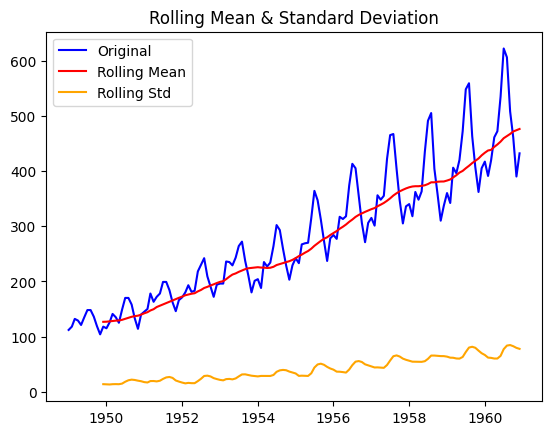

In [11]:
rolmean = df_main.rolling(window=12).mean() 
rolstd = df_main.rolling(window=12).std()


orig = plt.plot(df_main, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='orange', label='Rolling Std')


plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

- видно, что с каждым годом число пассажиров растет.` С ростом числа пассажиров волатильность сезонных отклонений возрастает`!
- тренд в данных восходящий
- стандартное отклонение тоже имеет явный возрастающий тренд в данных.

- Оставим для аналитики данные с 1952 по 1957 год (включительно)

In [12]:
df = df_main.copy()
df = df['1952':'1957']
print(df.index.min(), df.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


b. Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

Для определения, является ли временной ряд стационарным выполним визуальный анализ и применим статистический тест Дики-Фуллера на стационарность.
 - строю график временного ряда, оцениваю его свойства, такие как тренд, сезонность и шум.
 - использую тест Дики-Фуллера (ADF тест) с помощью функции  `adfuller`  из  `statsmodels.tsa.stattools`  для проверки стационарности ряда. Результат теста включает ADF статистику, p-значение и критические значения. `Если p-значение меньше` выбранного уровня значимости (обычно 0.05), то мы можем `отклонить` нулевую гипотезу о `нестационарности` `и считать ряд стационарным.`

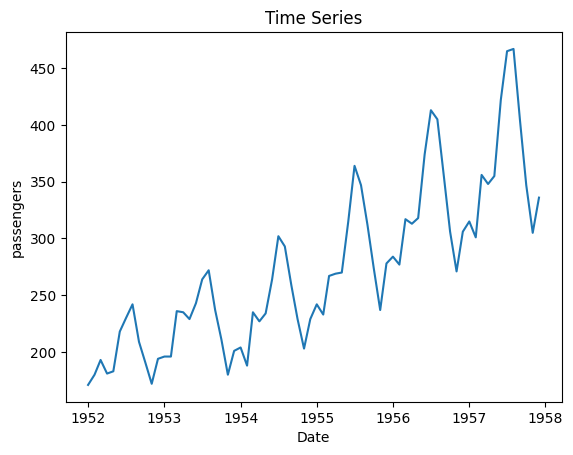

ADF Statistic: 0.8585175675118052
p-value: 0.9925243723978879
Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}


In [13]:
plt.plot(df['passengers'])
plt.xlabel('Date')
plt.ylabel('passengers')
plt.title('Time Series')
plt.show()

# Тест Дики-Фуллера на стационарность
result = adfuller(df['passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

- скорее всего, данные временного ряда `нестационарны`. Статистика ADF составляет 0,8585, а значение P = 0,992, это указывает на отсутствие доказательств для отклонения нулевой гипотезы о нестационарности. Также Критические значения для уровней значимости 1%, 5% и 10% сравниваются со статистикой ADF, и она превышает эти значения, что еще больше подтверждает вывод о нестационарности.

- выполняю сезонное разложение (seasonal decomposition) временного ряда, используя метод  `seasonal_decompose`

-  `model="additive"`  - в данном случае используется аддитивная модель модель разложения


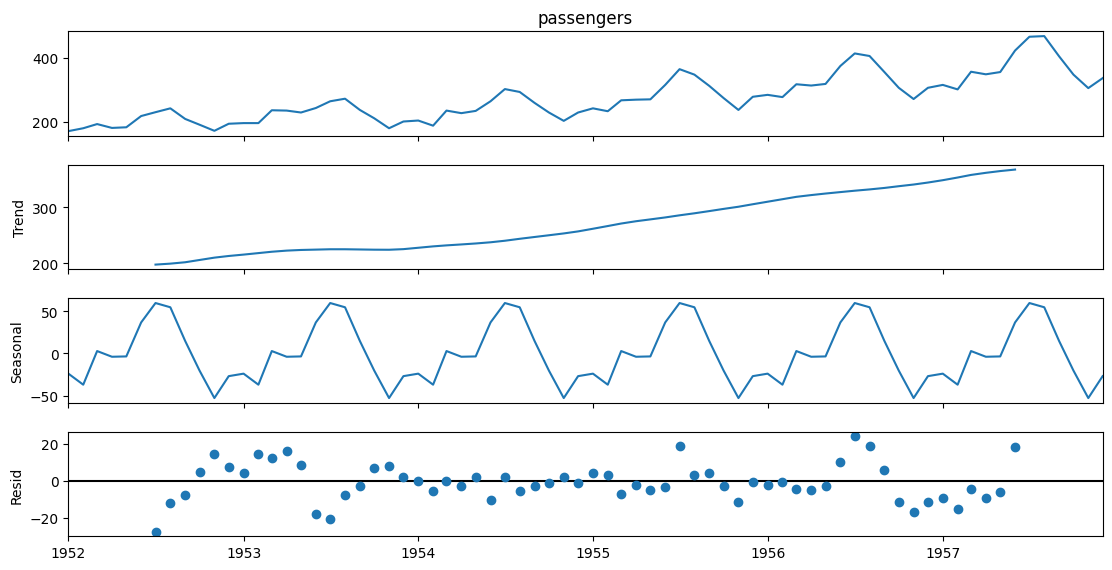

In [14]:
sdc = seasonal_decompose(df['passengers'], model = "aditive")
grfc = sdc.plot()
fig = grfc.get_figure()
fig.set_size_inches(12, 6)

- `тренд - Восходящий`
- Присутствует `месячная сезонность`, на графике присутствуют существенные повторяющиеся сезонные колебания 
- `Остатки` показывают, насколько точно модель сезонного разложения объясняет данные. В данном случае `достаточно точно`, так как отсутствуют систематические или нерегулярные паттерны в графике

 -  Построение графика автокорреляции

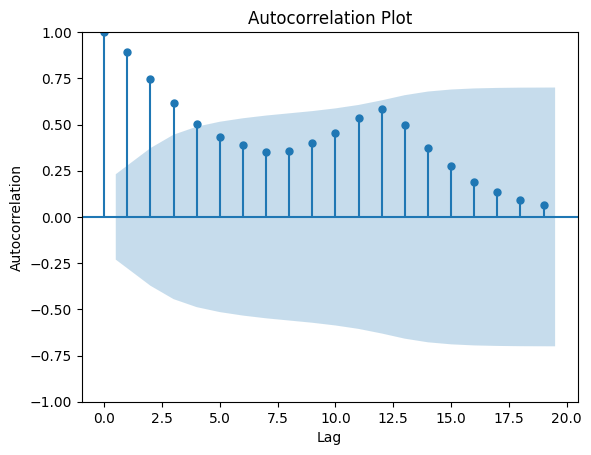

In [15]:
plot_acf(df['passengers'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

- используем функцию  `plot_acf`  из модуля  `statsmodels.graphics.tsaplots`  для построения графика автокорреляции. График показывает значения автокорреляции для разных лагов (задержек) временного ряда. По оси - X отображаются значения лага, а по оси - Y значения автокорреляции. 

- наблюдаю что значения автокорреляции на определенных лагах `значительно отличаются от нуля`, в данном случае это может указывать на `наличие` `сезонности` (или другой зависимости в данных).
- самая большая автокорреляция у нулевого сдвига, так как временной ряд не сдвинут в этот момент и полностью с собой коррелирует.
- одна из самых больших отсечек автокорреляции наблюдается на лаге - 12, то есть если сдвинуть отсечку на год, так как во временном ряду имеется ежегодная сезонность.
- так как `значения` `автокорреляции` `все` `выше` нуля делаем `однозначный` `вывод` `о наличии тренда`.
- `НО` так же можно сделать вывод, что почти все сдвиги (сдвиги которые не выходят за значения голубой области) кроме первых 5ти и одного на 12 месяцев не особо информативны с точки зрения прогнозирования временного ряда. В итоге `только два сдвига будут максимально информативными в районе 4 и 12.`


---------------------------
`3.	Подготовьте данные к обучению линейной модели`\
a.	Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)\
i.	Воспользуйтесь наработками из скринкастов.\
ii.	Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.\
iii.	Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».\
b.	Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.\
c.	Удалите наблюдения с пропусками в новых переменных.\
d.	Разделите данные на признаки и целевую переменную.\
e.	Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.


In [16]:
def generate_features(data, lag_n, rolling_mean_m):
    # Генерирование колонок с разными сдвигами
    for lag in lag_n:
        data[f'lag_{lag}'] = data['passengers'].shift(lag)
        
    # Генерирование колонок с разными скользящими средними
    for window_size in rolling_mean_m:
        column_name = f'rolling_mean_{window_size}'
        data[column_name] = data['passengers'].rolling(window_size).mean().shift(1) # shift(1) сдвиг, чтобы не было «заглядывания в будущее»
    
    return data

`lag_n` - список возможных сдвигов
`rolling_mean_m` - список возможных размеров скользящего среднего.


In [17]:
lag_n = [3, 4, 12]
rolling_mean_m = [2, 4, 12]

df_copy = df.copy()
result_df = generate_features(df_copy, lag_n, rolling_mean_m)
result_df.dropna(inplace=True)
result_df.head(5)

,passengers,lag_3,lag_4,lag_12,rolling_mean_2,rolling_mean_4,rolling_mean_12
date,,,,,,,
1953-01-01,196,191.00,209.00,171.00,183.00,191.50,197.00
1953-02-01,196,172.00,191.00,180.00,195.00,188.25,199.08
1953-03-01,236,194.00,172.00,193.00,196.00,189.50,200.42
1953-04-01,235,196.00,194.00,181.00,216.00,205.50,204.00
1953-05-01,229,196.00,196.00,183.00,235.50,215.75,208.50


In [18]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 1953-01-01 to 1957-12-01
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passengers       60 non-null     int64  
 1   lag_3            60 non-null     float64
 2   lag_4            60 non-null     float64
 3   lag_12           60 non-null     float64
 4   rolling_mean_2   60 non-null     float64
 5   rolling_mean_4   60 non-null     float64
 6   rolling_mean_12  60 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.8 KB


- Разделю данные на признаки и целевую переменную. Так как Задача -  спрогнозировать число пассажиров авиакомпании помесячно.
Целевой переменной будет столбец passengers в нашем новом DF - result_df

In [19]:
features, target = result_df.drop(columns='passengers'), pd.DataFrame(result_df['passengers'])

- Разделю данные на обучающую и валидационную части. Валидационная часть должна идти строго после обучающей

In [20]:
train_features, test_features = train_test_split(features, shuffle=False, test_size=0.2, random_state=45)
train_target, test_target = train_test_split(target, shuffle=False, test_size=0.2, random_state=45)

- выполним стандартизацию (нормализацию) признаков, чтобы привести их к нулевому среднему и единичному стандартному отклонению.

1. StandardScaler().fit(train_features) - вычислит среднее и стандартное отклонение каждого признака на основе тренировочных данных (train_features).

2. transform(train_features) - применяет стандартизацию к тренировочным данным, вычитая среднее и делая масштабирование на стандартное отклонение каждого признака. Результат сохраняется в переменной train_features_norm. Аналогично к тестовым данным (test_features).

In [21]:
scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

------------------------
4.	Обучите `линейную` модель машинного обучения и оцените ее качество\
a.	Обучите линейную модель на обучающей части данных.\
b.	Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.\
c.	Визуализируйте реальный временной ряд и прогнозные значения. 


In [22]:
scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

In [23]:
model = LinearRegression()
model.fit(train_features_norm, train_target)

train_prediction = model.predict(train_features_norm)
test_prediction = model.predict(test_features_norm)

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_prediction))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 10.783510197443848
MAE тестовой выборки:  14.360182914068934


- Визуализирую реальный временной ряд и прогнозные значения

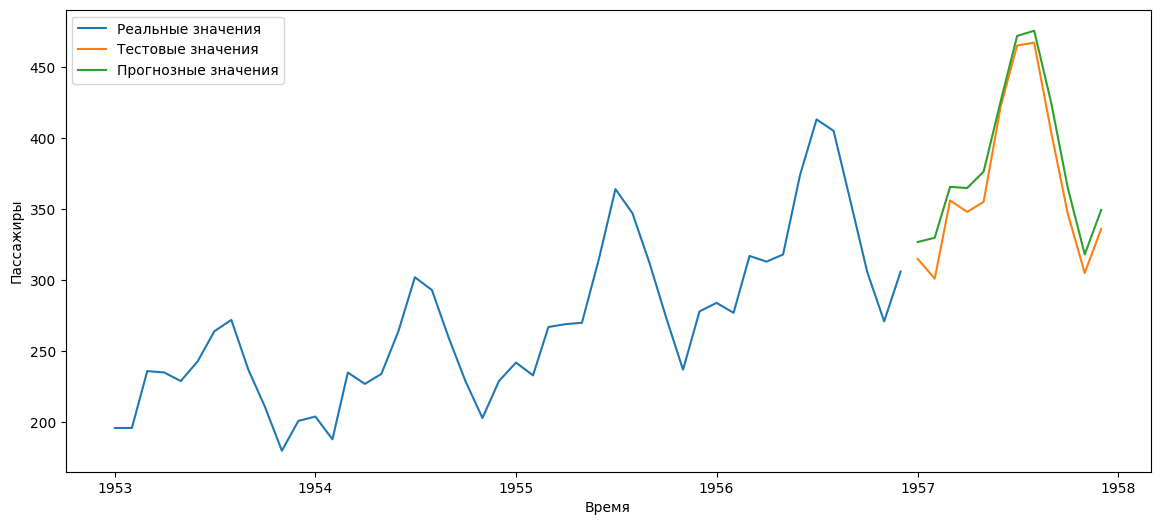

In [24]:
fig, ax = plt.subplots(figsize=[14, 6])

# Визуализация реального временного ряда
ax.plot(train_target.index, train_target['passengers'], label='Реальные значения')
ax.plot(test_target.index, test_target['passengers'], label='Тестовые значения')

# Визуализация прогнозных значений
ax.plot(test_target.index, test_prediction, label='Прогнозные значения')

ax.set_xlabel('Время')
ax.set_ylabel('Пассажиры')
ax.legend()
plt.show()

----------------------------
5.	Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год\
a.	Возьмите из источника необходимый срез данных.\
b.	Подготовьте данные к прогнозированию.\
i.	Добавьте признаки с помощью реализованной ранее функции.\
ii.	Удалите наблюдения с пропусками.\
iii.	Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.\
iv.	Отделите целевую переменную от признаков.\
c.	Постройте прогноз с помощью обученной ранее линейной модели.\
d.	Рассчитайте значение метрики качества на отложенной выборке.\
e.	Визуализируйте реальный временной ряд и прогнозные значения.


- использую ранее подготовленные данный из главного датасета df_main.

- Срез скорректирован

In [25]:
df_5760 = df_main.copy()
df_5760 = df_5760['1956':'1960']
print(df_5760.index.min(), df_5760.index.max())

1956-01-01 00:00:00 1960-12-01 00:00:00


In [26]:
df_5760.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 1956-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


- i. Добавляю признаки с помощью реализованной ранее функции.

`lag_n` - список возможных сдвигов

`rolling_mean_m` - список возможных размеров скользящего среднего.

In [27]:
lag_n = [6, 8, 12]
rolling_mean_m = [6, 8, 12]

df_5760с = df_5760.copy()
result_df_5760 = generate_features(df_5760с, lag_n, rolling_mean_m)
result_df_5760.dropna(inplace=True)
result_df_5760.head(5)

,passengers,lag_6,lag_8,lag_12,rolling_mean_6,rolling_mean_8,rolling_mean_12
date,,,,,,,
1957-01-01,315,413.00,318.00,284.00,342.67,343.50,328.25
1957-02-01,301,405.00,374.00,277.00,326.33,343.12,330.83
1957-03-01,356,355.00,413.00,317.00,309.00,334.00,332.83
1957-04-01,348,306.00,405.00,313.00,309.17,326.88,336.08
1957-05-01,355,271.00,355.00,318.00,316.17,319.75,339.00


In [28]:
result_df_5760.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 1957-01-01 to 1960-12-01
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passengers       48 non-null     int64  
 1   lag_6            48 non-null     float64
 2   lag_8            48 non-null     float64
 3   lag_12           48 non-null     float64
 4   rolling_mean_6   48 non-null     float64
 5   rolling_mean_8   48 non-null     float64
 6   rolling_mean_12  48 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.0 KB


iv.	Отделите целевую переменную от признаков.


In [29]:
features_5760, target_5760 = result_df_5760.drop(columns='passengers'), pd.DataFrame(result_df_5760['passengers'])

train_features_5760, test_features_5760 = train_test_split(features_5760, shuffle=False, test_size=0.2, random_state=45)

train_target_5760, test_target_5760 = train_test_split(target_5760, shuffle=False, test_size=0.2, random_state=45)

c.	Постройте прогноз с помощью обученной ранее линейной модели.

In [30]:
scaler_5760_f = StandardScaler().fit(train_features_5760)
train_features_norm_5760 = scaler_5760_f.transform(train_features_5760)
test_features_norm_5760 = scaler_5760_f.transform(test_features_5760)


d.	Рассчитайте значение метрики качества на отложенной выборке.


Применим нашу модель model к нормализованным данным отложенной выборке

In [31]:
model_5760 = model.fit(train_features_norm_5760, train_target_5760)

train_prediction_5760 = model_5760.predict(train_features_norm_5760)
test_prediction_5760 = model_5760.predict(test_features_norm_5760)

print("MAE обучающей выборки:" ,mean_absolute_error(train_target_5760, train_prediction_5760))
print("MAE на отложенной выборке: " ,mean_absolute_error(test_target_5760, test_prediction_5760))

MAE обучающей выборки: 14.750460830151706
MAE на отложенной выборке:  17.411587912176383



e.	Визуализируйте реальный временной ряд и прогнозные значения.

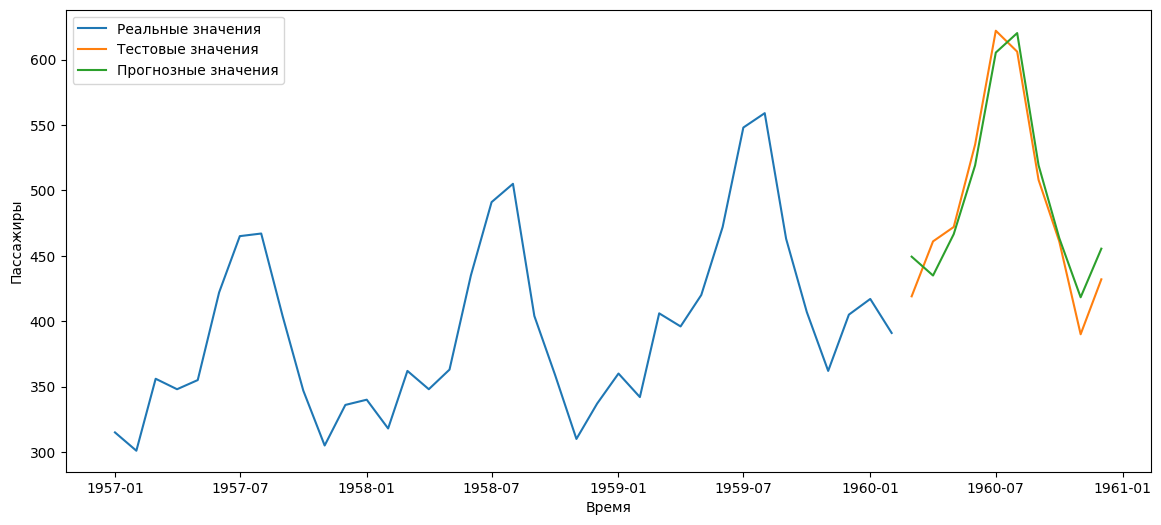

In [32]:
fig, ax = plt.subplots(figsize=[14, 6])

# Визуализация реального временного ряда
ax.plot(train_target_5760.index, train_target_5760['passengers'], label='Реальные значения')
ax.plot(test_target_5760.index, test_target_5760['passengers'], label='Тестовые значения')

# Визуализация прогнозных значений
ax.plot(test_target_5760.index, test_prediction_5760, label='Прогнозные значения')

ax.set_xlabel('Время')
ax.set_ylabel('Пассажиры')
ax.legend()
plt.show()

-------------------------
6.	Значение метрики MAE на отложенной выборке должно быть не более 35.

 - MAE на отложенной выборке получилось:  17.411587912176383

`Выводы`
- в процессе работы попрактиковался в обучении моделей на временных рядах.
- получилось предсказать следующие колебания значений на графике
- попрактиковался в нормализации данных
- попрактиковался в построении графика автокорреляции и его интерпретировании
- использовал Тест Дики-Фуллера на стационарность